In [ ]:
# %pip uninstall envirocar-py -y
# %pip install overpass

Min X: 7.62918783
Min Y: 51.95400748
Max X: 7.65293855
Max Y: 51.95982125
ele is not a valid column in input nodes. Ignoring this column.
timestamp is not a valid column in input nodes. Ignoring this column.
sat is not a valid column in input nodes. Ignoring this column.


AttributeError: module 'osmnx' has no attribute 'features'

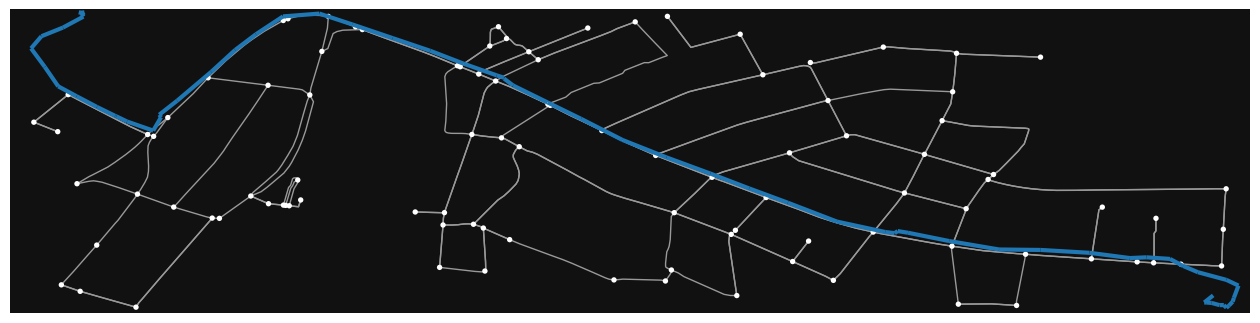

In [1]:
# %load_ext autoreload
# %autoreload 2

# load dependencies'
import concurrent.futures
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import osmnx as ox
import networkx as nx

import requests
import json
from urllib.parse import urljoin

import mm_utils

def conc(a):
    #function to convert list or integer in osmid into a unique string id 
    if type(a) is int:
        return str(a)
    ans = ",".join(map(str, a))
    return ans

url = "https://envirocar.org/api/stable/tracks/52f3836be4b0d8e8c27ed6f0"
response = requests.get(url)
data = json.loads(response.text)

geometries = []
attributes = []

for feature in data['features']:
    geometry = shape(feature['geometry'])
    geometries.append(geometry)
    attributes.append(feature['properties'])

gdf = gpd.GeoDataFrame(data=attributes, geometry=geometries)

# Get the bounding box
bbox = gdf.total_bounds

# 'total_bounds' returns a tuple with (minx, miny, maxx, maxy) values
minx, miny, maxx, maxy = bbox

# Print the bounding box values
print("Min X:", minx)
print("Min Y:", miny)
print("Max X:", maxx)
print("Max Y:", maxy)

G=nx.Graph()

#座標を指定し地図データをダウンロード
G = ox.graph.graph_from_bbox(maxy, miny, maxx, minx, network_type='drive')
fig, ax = ox.plot_graph(G, figsize = (16,16),show=False,close=False)

tripdata_edges = mm_utils.point_to_traj(gdf, columns = {'ele': 'average',
                                                                  'timestamp':'first',
                                                                  'sat':'first'})
tripdata_edges.plot(ax=ax, linewidth=3)

campus = ox.features.features_from_place('Somewhere', tags = {'name':True})
campus.plot(ax=ax, alpha=0.5)


In [7]:
# see the data structure of geopanda dataframe 
nodes_utm


,y,x,highway,street_count,lon,lat,geometry,lon_lat
osmid,,,,,,,,
21518865,5.756860e+06,405840.628948,traffic_signals,3,7.629784,51.954459,POINT (405840.629 5756859.733),POINT (7.62978 51.95446)
43601038,5.756845e+06,405865.780609,NaN,3,7.630154,51.954332,POINT (405865.781 5756845.119),POINT (7.63015 51.95433)
21518866,5.756946e+06,405890.085476,NaN,3,7.630480,51.955241,POINT (405890.085 5756945.802),POINT (7.63048 51.95524)
21518867,5.757056e+06,405947.230837,traffic_signals,4,7.631281,51.956243,POINT (405947.231 5757056.281),POINT (7.63128 51.95624)
60358392,5.757027e+06,405995.703628,NaN,3,7.631994,51.955988,POINT (405995.704 5757027.011),POINT (7.63199 51.95599)
...,...,...,...,...,...,...,...,...
1932959986,5.757039e+06,406167.628077,turning_circle,1,7.634492,51.956129,POINT (406167.628 5757039.378),POINT (7.63449 51.95613)
9776435595,5.757027e+06,406151.901920,NaN,3,7.634266,51.956015,POINT (406151.902 5757026.979),POINT (7.63427 51.95601)
10548918654,5.756978e+06,407322.917698,NaN,1,7.651316,51.955767,POINT (407322.918 5756977.628),POINT (7.65132 51.95577)


In [4]:
# phenomenons contains trajectory information of each time point in dictionary format
# example of extracting phenomenons from first data point
dict = gdf['phenomenons'][0]

# create array that save trajectory information that we want to extract 
key_list = ['GPS Speed', 'GPS HDOP', 'GPS Bearing']

# Initialize data frame 
df = pd.DataFrame()

# loop to get trajectory infos for each point 
for key in key_list:
    temp = []
    for i in range(gdf.shape[0]):
        dict_temp = gdf['phenomenons'][i]
        if key in dict_temp:
            temp.append(dict_temp[key]['value'])
        else:
            temp.append(float("nan"))
    df[key] = temp


# combine geodata frame with the new extracted info    
gdf = pd.concat([gdf, df],axis = 1)

In [5]:
# get road network 
# Get the bounding box
bbox = gdf.total_bounds

# 'total_bounds' returns a tuple with (minx, miny, maxx, maxy) values
minx, miny, maxx, maxy = bbox

# Download a map by specifying the bounding box
# and draw the graph
G = ox.graph.graph_from_bbox(maxy, miny, maxx, minx, network_type='drive') 

graph_proj = ox.project_graph(G)
nodes_utm, edges_utm = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)

# extract road info 
nodes, edges = ox.graph_to_gdfs(G)

# append latitude and longitude to utm edges 
edges_utm['lon_lat'] = edges['geometry']

# convert osmid into unique string id 
edges_utm['str_id'] = edges_utm['osmid'].apply(conc)

# append latitude and longitude to utm edges 
nodes_utm['lon_lat'] = nodes['geometry']


In [47]:
# convert gdf to utm 31 projection 
# initialize projection to standard WGS 84 
gdf.crs = {'init': 'epsg:4326'}

# grab the estimated projection type needed
utm_crs = gdf.estimate_utm_crs()

# convert gdf to UTM projection  
gdf_utm = gdf.to_crs(utm_crs)

# append latitude and longitude to utm edges 
gdf_utm['lon_lat'] = gdf['geometry']

# convert time str to datetime
gdf_utm['time'] = pd.to_datetime(gdf_utm['time'])

C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [49]:
gdf_utm['speed_mps'] = gdf_utm['GPS Speed']/3.6

In [53]:
# save data frame 
gdf.to_pickle('envirocar.pkl')
gdf_utm.to_pickle('gdf_utm.pkl')
edges_utm.to_pickle('edges_utm.pkl')
nodes_utm.to_pickle('nodes_utm.pkl')